In [1]:
import gs

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [3]:
import numpy as np

In [4]:
x = np.linspace(-1,1,1000)
V = np.array([x**n for n in range(100)])

In [56]:
a = gs.cgs(V, return_orthonormal=True)

In [57]:
b = gs.mgs(V, return_orthonormal=True)

In [135]:
c = gs.imgs(V, return_orthonormal=False)

In [5]:
c = gs._imgs_galley(V)

In [80]:
gs.check_basis(a, check_unit_length=True)

error is 64.33241177637355
condition number is 3.303078812292505e+16


In [81]:
gs.check_basis(b, check_unit_length=True)

error is 30.375579823139397
condition number is 7.345229217119683


In [143]:
gs.check_basis(c, check_unit_length=True)

error is 29.999999999999996
condition number is 1.0000000000000022


In [6]:
gs.check_basis(c)

error is 31.50864300958953
condition number is 2.5760946711919124e+16


In [8]:
import rompy as rp
integration = rp.Integration([-1, 1], num=len(x), rule='riemann')
gramschmidt = rp.GramSchmidt(V, integration)
basis = gramschmidt.make()
# basis = gs.compute_Uhat(basis)

In [145]:
gs.check_basis(basis, check_unit_length=True)

error is 30.0
condition number is 1.000000000000002


In [9]:
gs.check_basis(basis)

error is 4985.0902699951175
condition number is 1.0000000000000016


In [85]:
def compute_svd(matrix):
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)
    return u,s,vh

u, s, vh = compute_svd(V)

In [86]:
gs.check_basis(vh)

error is 29.999999999999996
condition number is 1.0000000000000009


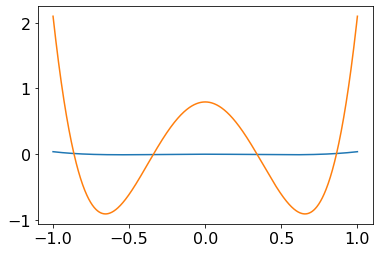

In [12]:
idx=4
plt.figure()
plt.plot(x, c[idx])
plt.plot(x, basis[idx])


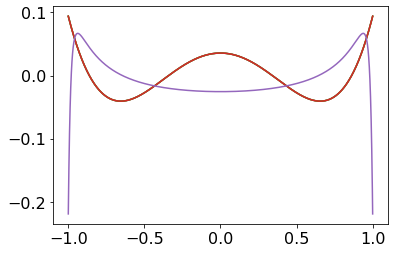

In [107]:
idx=4
plt.figure()
plt.plot(x, a[idx])
plt.plot(x, b[idx])
plt.plot(x, c[idx])
plt.plot(x, basis[idx])
plt.plot(x, vh[idx])

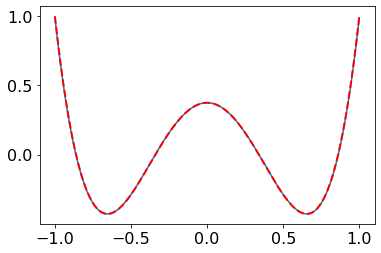

In [134]:
# Plot the fourth Legendre polynomial

# Plot basis elements divided by sqrt(l+1/2)
idx=4
ell = idx

plt.figure()

# plt.plot(x, c[ell]/np.sqrt(ell+1./2.))
plt.plot(x, basis[ell]/np.sqrt(ell+1./2.))



# plt.plot(x, a[idx])
# plt.plot(x, b[idx])
# plt.plot(x, c[idx])
# plt.plot(x, basis[idx])
# plt.plot(x, vh[idx])

from numpy.polynomial.legendre import legval
plt.plot(x, legval(x,[0,0,0,0,1,0,0,0,0,0]), 'r--', linewidth=2);

In [16]:
from scipy.linalg import hilbert

In [27]:
print("random matrix example")

n=200
A = np.random.rand(n,n)

print("cgs")
Q = gs.cgs(A)
gs.check_basis(Q)

print("\n\n")

print("mgs")
Q = gs.mgs(A)
gs.check_basis(Q)

print("\n\n")

print("imgs")
Q = gs.imgs(A)
gs.check_basis(Q)


print("\n\n")

print("SVD")
_, _, Q = compute_svd(A)
gs.check_basis(Q)

random matrix example
cgs
error is 3.3832974076090166e-11
condition number is 1.0000000000237628



mgs
error is 4.961641694167203e-13
condition number is 1.000000000000342



imgs
error is 7.870287437050679e-15
condition number is 1.0000000000000013



SVD
error is 2.9288594805320994e-14
condition number is 1.000000000000001


In [28]:
print("hilbert matrix example")

n=200
A = 0.00001*np.eye(n) + hilbert(n)


print("cgs")
Q = gs.cgs(A)
gs.check_basis(Q)

print("\n\n")

print("mgs")
Q = gs.mgs(A)
gs.check_basis(Q)

print("\n\n")

print("imgs")
Q = gs.imgs(A)
gs.check_basis(Q)

print("\n\n")

print("SVD")
_, _, Q = compute_svd(A)
gs.check_basis(Q)

hilbert matrix example
cgs
error is 0.2422811195526351
condition number is 1.133658103111947



mgs
error is 2.2012110218768266e-11
condition number is 1.0000000000105858



imgs
error is 5.755253834421279e-15
condition number is 1.000000000000002



SVD
error is 1.5275589987984498e-14
condition number is 1.0000000000000018


# try using integration rather than dot-product

In [113]:
from scipy.integrate import simps, trapz, romb, cumtrapz

In [47]:
def integration_imgs_galley(a, x, rule, tol=0.5, max_iter=3):
    """
    implementation of Chad Galley's code
    for the iterative modified gram-schmodt algorithm
    https://bitbucket.org/chadgalley/rompy/src/master/greedy.py

    used only to debug my version.

    One should not need to use this function
    
    rule: type: str
        either 'trap' or 'riemann'
    """
    
    def inner_fun(a, b, x, rule):
#         return np.trapz(a*b, x=x)
#         return simps(a*b, x=x)
#         return trapz(a*b, x=x)
#         return cumtrapz(a*b, x=x)
#         return romb(a*b)

        aa=x[0]
        bb=x[-1]
        n=len(x)
        nodes = np.linspace(x[0], x[-1], num=len(x))
        
        if rule == 'trap':
            weights = np.ones(n, dtype='double')
            weights[0] = 0.5
            weights[-1] = 0.5
        elif rule == 'riemann':
            weights = np.ones(n, dtype='double')
        elif rule == 'np.trapz':
            return np.trapz(a*b, x=x)
            
        weights = (bb-aa)/(n-1.) * weights
        return np.dot(weights, a*b)




    
    def norm_fun(a, x, rule):
        return np.sqrt(inner_fun(a,a, x=x, rule=rule))
    
    n_vectors = a.shape[0]
    n_dim = a.shape[1]

    basis = np.zeros(shape=(n_vectors, n_dim))
#     basis[0] = a[0] / np.linalg.norm(a[0])
    basis[0] = a[0] / norm_fun(a[0], x, rule)

    for ii in range(1, n_vectors):
        h = a[ii]
        bb = basis[:ii]

#         norm = np.linalg.norm(h)
        norm = norm_fun(h, x, rule)
        e = h / norm

        flag, ctr = 0, 1
        while flag == 0:

            for b in bb:

#                 e -= b * np.dot(b, e)
                e -= b * inner_fun(b, e, x, rule)

#             new_norm = np.linalg.norm(e)
            new_norm = norm_fun(e, x, rule)

            if new_norm / norm <= tol:
                norm = new_norm
                ctr += 1
                if ctr > max_iter:
                    msg = "WARNING max number of iter reached " \
                    + "basis may not be orthonormal."
                    print(msg)
                    flag = 1
            else:
                flag = 1

        basis[ii] = e/new_norm

    return basis


In [48]:
x = np.linspace(-1,1,2**13)
V = np.array([x**n for n in range(100)])

In [32]:
new_b = integration_imgs_galley(V, x=x, rule='trap')
gs.check_basis(new_b)
# new_b = gs.compute_Uhat(new_b)
# gs.check_basis(new_b)

error is 41425.79966093435
condition number is 1.230698364013149


In [46]:
new_b = integration_imgs_galley(V, x=x, rule='riemann')
gs.check_basis(new_b)
# new_b = gs.compute_Uhat(new_b)
# gs.check_basis(new_b)

error is 40945.09881536508
condition number is 1.0000000000000016


In [51]:
new_b = integration_imgs_galley(V, x=x, rule='np.trapz')
gs.check_basis(new_b)
# new_b = gs.compute_Uhat(new_b)
# gs.check_basis(new_b)

error is 89.95824912614204
condition number is 1.228551387221139


In [168]:
import rompy as rp


integration = rp.Integration([-1, 1], num=len(x), rule='trapezoidal')
# integration = rp.Integration([-1, 1], num=len(x), rule='riemann')
# integration = rp.Integration([-1, 1], num=len(x), rule='chebyshev')
# integration = rp.Integration([-1, 1], num=len(x), rule='chebyshev-lobatto')
gramschmidt = rp.GramSchmidt(V, integration)
basis = gramschmidt.make()

gs.check_basis(basis)
# basis = gs.compute_Uhat(basis)
# gs.check_basis(basis)

error is 41425.79966093435
condition number is 1.230698364013149


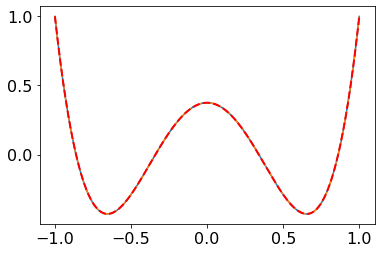

In [163]:
# Plot the fourth Legendre polynomial

# Plot basis elements divided by sqrt(l+1/2)
idx=4
ell = idx

plt.figure()


plt.plot(x, new_b[ell]/np.sqrt(ell+1./2.))

plt.plot(x, basis[ell]/np.sqrt(ell+1./2.), ls='-.')



# plt.plot(x, a[idx])
# plt.plot(x, b[idx])
# plt.plot(x, c[idx])
# plt.plot(x, basis[idx])
# plt.plot(x, vh[idx])

from numpy.polynomial.legendre import legval
plt.plot(x, legval(x,[0,0,0,0,1,0,0,0,0,0]), 'r--', linewidth=2);

# try some other function not on [-1,1]

In [106]:
from scipy.special import jv as BesselJ

nu = np.linspace(0, 100, 1001)

# Make integration rule
# integration = rp.Integration([0, 1000], num=10001, rule='trapezoidal')
# integration = rp.Integration([0, 100], num=1001, rule='riemann')
integration = rp.Integration([0, 100], num=1001, rule='trapezoidal')
x = integration.nodes  # Define x for convenience

In [107]:
# NOTE: Generating the training space may take a few minutes
training = np.array([BesselJ(nn, x) for nn in nu])

In [111]:
gramschmidt = rp.GramSchmidt(training, integration)
basis = gramschmidt.make()

gs.check_basis(basis)

error is 285.72889248376686
condition number is 1.4142135623730965


In [112]:
gs.check_basis(gs.compute_Uhat(basis))

error is 1.108042059021492
condition number is 1.7164230740645998


In [113]:
new_b = integration_imgs_galley(training, x=x, rule='trap')
gs.check_basis(new_b)

error is 285.72889248376686
condition number is 1.4142135623730965


In [114]:
gs.check_basis(gs.compute_Uhat(new_b))

error is 1.108042059021492
condition number is 1.7164230740645998


In [115]:
new_b = integration_imgs_galley(training, x=x, rule='riemann')
gs.check_basis(new_b)

error is 284.74725635201474
condition number is 1.0000000000000027


In [116]:
gs.check_basis(gs.compute_Uhat(new_b))

error is 2.935387543901302e-14
condition number is 1.0000000000000027


In [109]:
_, _, vh = np.linalg.svd(training, full_matrices=True)

In [110]:
gs.check_basis(vh)

error is 5.039227759902802e-14
condition number is 1.0000000000000016


In [202]:
a = -1
b = 1
n = 10
weights = np.ones(n, dtype='double')
weights = (b-a)/(n-1) * weights


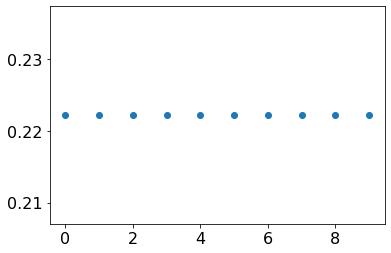

In [206]:
plt.scatter(range(n), weights)

In [71]:
def my_reim(x, y):
    a = x[0]
    b = x[-1]
    n = len(x)
    weights = np.ones(n, dtype='double')
    weights = (b-a)/(n-1) * weights
    
    return np.dot(weights, y)

In [72]:
def my_trap(x, y):
    a = x[0]
    b = x[-1]
    n = len(x)
    weights = np.ones(n, dtype='double')
    weights[0]=0.5
    weights[-1]=0.5
    weights = (b-a)/(n-1) * weights
    
    return np.dot(weights, y)

In [126]:
x = np.linspace(0, 20, 10000)

# y = x**100
y = np.sin(x)

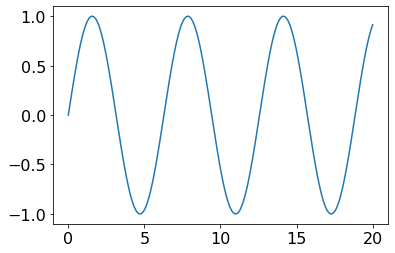

In [127]:
plt.figure()
plt.plot(x, y)

In [128]:
np.trapz(y, x)

0.5919177408411485

In [129]:
my_trap(x, y)

0.5919177408411485

In [130]:
my_reim(x, y)

0.5928307773955315

In [134]:
import rompy as rp
quad = rp.QuadratureRules()
nodes1, weights1 = quad['riemann']([0, 20], num=len(x))

int1 = rp.Integration(nodes=nodes1, weights=weights1)

# int1.integral(nodes1**100)
int1.integral(np.sin(nodes1))

0.5928307773955315

In [135]:
quad = rp.QuadratureRules()
nodes1, weights1 = quad['riemann']([0, 20], num=len(x)*1000)

int1 = rp.Integration(nodes=nodes1, weights=weights1)

# int1.integral(nodes1**100)
int1.integral(np.sin(nodes1))

0.5919188511317541

In [136]:
quad = rp.QuadratureRules()
nodes1, weights1 = quad['trapezoidal']([0, 20], num=len(x)*1000)

int1 = rp.Integration(nodes=nodes1, weights=weights1)

# int1.integral(nodes1**100)
int1.integral(np.sin(nodes1))

0.5919179381864121